In [1]:
from mandala._next.imports import *
from mandala._next.common_imports import *
from mandala._next.utils import *

In [ ]:
# set the logging level to DEBUG
# get the root logger
logger = logging.getLogger()
# set the logging level
logger.setLevel(logging.DEBUG)

In [2]:
### some example functions
@op
def inc(x: int) -> int:
    return x + 1

@op
def divmod(x: int, y: int) -> Tuple[int, int]:
    return x // y, x % y

@op # a function with a wild input signature
def add(x, *args, y: int = 1, **kwargs):
    # just sum everything
    return x + sum(args) + y + sum(kwargs.values())

@op # a function with a variable number of outputs
def factorize(n: int) -> Tuple[int, ...]:
    factors = []
    for i in range(2, n + 1):
        while n % i == 0:
            factors.append(i)
            n //= i
    return tuple(factors)

@op # function with list input and dict output
def get_stats(nums: MList[Any]) -> MDict[str, float]:
    return {
        'avg': float(sum(nums) / len(nums)),
        'sum': float(sum(nums)),
    }

# Examples of interesting CFs

In [3]:
### pipeline where some intermediate nodes contain source/sink refs
storage = Storage()

In [4]:
with storage:
    total_inputs = [1, 2, 3, 4, 5]
    intermediate_inputs = [6, 7, 8, 9, 10]

    res_1 = [inc(x) for x in total_inputs]
    res_2 = [divmod(x, 1)[0] for x in res_1 + intermediate_inputs]
    res_3 = [factorize(x) for x in [res_2[i] for i in range(0, len(res_2), 2)]]

[18:29:22] INFO     Caching new op inc.                                                              storage.py:258

           INFO     Caching new op divmod.                                                           storage.py:258

           INFO     Caching new op factorize.                                                        storage.py:258

Found the following number elements to expand in direction back:
  {'output_0': 0, 'output_1': 0, 'x': 10, 'y': 1}
Found 5 calls to expand
Expanding call group for op 'inc' with 5 calls, connections:
  output_0: ('x',)
Adding function inc for group ('inc', (('output_0', ('x',)),))
Found the following number elements to expand in direction back:
  {'output_0': 0, 'output_1': 0, 'x': 5, 'x_0': 5, 'y': 1}
Found 0 calls to expand
Found the following number elements to expand in direction forward:
  {'output_0': 10, 'output_1': 10, 'x': 0, 'x_0': 0, 'y': 0}
Found 5 calls to expand
Expanding call group for op 'factorize' with 5 calls, connections:
  n: ('output_0',)
Adding function factorize for group ('factorize', (('n', ('output_0',)),))
Found the following number elements to expand in direction forward:
  {'output_0': 5,
   'output_0_0': 5,
   'output_1': 10,
   'output_1_0': 3,
   'x': 0,
   'x_0': 0,
   'y': 0}
Found 0 calls to expand
Found the following number elements to expand in dir

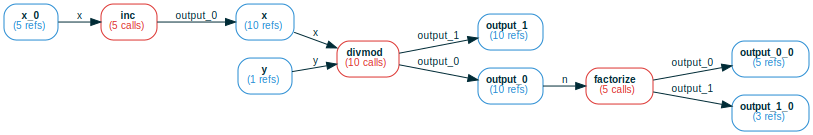

Extracting tuples from the computation graph:
    x@output_0 = inc(x=x_0)
    output_0@output_0, output_1@output_1 = divmod(x=x, y=y)
    output_0_0@output_0, output_1_0@output_1 = factorize(n=output_0)


,y,x_0,x,output_1,output_0,output_1_0,output_0_0
0,1,3.0,4,0,4,2.0,2.0
1,1,5.0,6,0,6,3.0,2.0
2,1,NaN,9,0,9,3.0,3.0
3,1,NaN,7,0,7,NaN,7.0
4,1,1.0,2,0,2,NaN,2.0
5,1,NaN,8,0,8,NaN,NaN
6,1,4.0,5,0,5,NaN,NaN
7,1,NaN,10,0,10,NaN,NaN
8,1,2.0,3,0,3,NaN,NaN
9,1,NaN,6,0,6,NaN,NaN


In [5]:
cf = storage.cf(divmod).expand(verbose=True)
cf.draw(); display(cf.get_df(include_calls=False))

In [6]:
### a pipeline where the same function is called in multiple places in the graph
storage = Storage()
with storage:
    inputs = [1, 2, 3, 4, 5]
    res_1 = [inc(x) for x in inputs]
    res_2 = [divmod(x, 1)[0] for x in res_1]
    res_3 = [inc(x) for x in res_2]

[18:29:28] INFO     Caching new op inc.                                                              storage.py:258

           INFO     Caching new op divmod.                                                           storage.py:258

In [15]:
storage.unwrap(res_3)

[3, 4, 5, 6, 7]

In [20]:
cf['output_0'].refs

{'c3a3ddc0eb745b3a9c377c9fe8623d4e': AtomRef(hid='c3a...', cid='489...', in_memory=False),
 'f1f436378b2872e2ccfeba711af716ec': AtomRef(hid='f1f...', cid='76f...', in_memory=False),
 'f774c7bb9eeb18f219920d20ab88009e': AtomRef(hid='f77...', cid='785...', in_memory=False),
 'e639b35c92f64629b5a40cc8215fddda': AtomRef(hid='e63...', cid='a82...', in_memory=False),
 '960515500c92e27fbf646a584ce8edff': AtomRef(hid='960...', cid='566...', in_memory=False)}

In [22]:
cf['output_0'].refs

{'c3a3ddc0eb745b3a9c377c9fe8623d4e': AtomRef(hid='c3a...', cid='489...', in_memory=False),
 'f1f436378b2872e2ccfeba711af716ec': AtomRef(hid='f1f...', cid='76f...', in_memory=False),
 'f774c7bb9eeb18f219920d20ab88009e': AtomRef(hid='f77...', cid='785...', in_memory=False),
 'e639b35c92f64629b5a40cc8215fddda': AtomRef(hid='e63...', cid='a82...', in_memory=False),
 '960515500c92e27fbf646a584ce8edff': AtomRef(hid='960...', cid='566...', in_memory=False)}

In [24]:
storage.get_consumers(ref_hids=cf['output_0'].refs.keys())

{'c00b55f93e75f663d71d4a1bd4e3f34e'}


[Call(inc, cid='864...', hid='c00...')]

In [25]:
storage.preload()

In [31]:
storage.calls.cache.df.query('op == "inc"').index.get_level_values(0).nunique()

10

In [27]:
ref_hids=cf['output_0'].refs.keys()
storage.calls.cache.df.query('ref_history_id in @ref_hids')

,,direction,call_content_id,ref_content_id,ref_history_id,op,semantic_version,content_version
call_history_id,name,,,,,,,
12847d50eec6c92ee798485240173e12,output_0,out,96a9b22b00cf93f326901f38a6dd2ad8,4896dd6b3bd5bdfcbb5222192e4e2042,c3a3ddc0eb745b3a9c377c9fe8623d4e,divmod,None,None
261af0862729c08b45ab1f43f2dd1e1d,output_0,out,ac3669bb6da4961581ed2326ad4e697b,76f34d73a1a6753d1243c9ba0afe3457,f1f436378b2872e2ccfeba711af716ec,divmod,None,None
00c7379594aa48056047abd4c14d72bb,output_0,out,39eacf2eb1b4eaa167981467c9523d90,785ee38e51369f64df4f68af923b3456,f774c7bb9eeb18f219920d20ab88009e,divmod,None,None
c00b55f93e75f663d71d4a1bd4e3f34e,x,in,864949bca0209a7349cd9b4413f43508,4896dd6b3bd5bdfcbb5222192e4e2042,c3a3ddc0eb745b3a9c377c9fe8623d4e,inc,None,None
0342fe30e9907992b40d655803612c6a,output_0,out,1855c21ae0e58eb50217836149809a18,a8216e26a2093b48a0b7c57159313c8e,e639b35c92f64629b5a40cc8215fddda,divmod,None,None
9de4daabea9bbcccd4150b76511d3bac,output_0,out,83a2979b9267088763481afb84b8127a,56615ea01687173ebab08c915ad7e500,960515500c92e27fbf646a584ce8edff,divmod,None,None


Found the following number elements to expand in direction back:
  {'output_0': 0, 'output_1': 0, 'x': 5, 'y': 1}
Found 5 calls to expand
Expanding call group for op 'inc' with 5 calls, connections:
  output_0: ('x',)
Adding function inc for group ('inc', (('output_0', ('x',)),))
Found the following number elements to expand in direction back:
  {'output_0': 0, 'output_1': 0, 'x': 0, 'x_0': 5, 'y': 1}
Found 0 calls to expand
Found the following number elements to expand in direction forward:
  {'output_0': 5, 'output_1': 5, 'x': 0, 'x_0': 0, 'y': 0}
Found 5 calls to expand
Expanding call group for op 'inc' with 5 calls, connections:
  x: ('output_0',)
Adding function inc_0 for group ('inc', (('x', ('output_0',)),))
Found the following number elements to expand in direction forward:
  {'output_0': 0, 'output_0_0': 5, 'output_1': 5, 'x': 0, 'x_0': 0, 'y': 0}
Found 0 calls to expand
Found the following number elements to expand in direction back:
  {'output_0': 0, 'output_0_0': 0, 'output

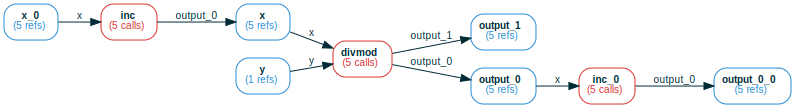

Extracting tuples from the computation graph:
    x@output_0 = inc(x=x_0)
    output_0@output_0, output_1@output_1 = divmod(x=x, y=y)
    output_0_0@output_0 = inc_0(x=output_0)


,y,x_0,inc,x,divmod,output_1,output_0,inc_0,output_0_0
0,1,3,"Call(inc, cid='be7...', hid='807...')",4,"Call(divmod, cid='185...', hid='034...')",0,4,"Call(inc, cid='dae...', hid='90a...')",5
1,1,1,"Call(inc, cid='9ee...', hid='7b8...')",2,"Call(divmod, cid='ac3...', hid='261...')",0,2,"Call(inc, cid='297...', hid='ee6...')",3
2,1,5,"Call(inc, cid='8d9...', hid='226...')",6,"Call(divmod, cid='96a...', hid='128...')",0,6,"Call(inc, cid='864...', hid='c00...')",7
3,1,4,"Call(inc, cid='dae...', hid='a50...')",5,"Call(divmod, cid='39e...', hid='00c...')",0,5,"Call(inc, cid='8d9...', hid='a7d...')",6
4,1,2,"Call(inc, cid='297...', hid='f1a...')",3,"Call(divmod, cid='83a...', hid='9de...')",0,3,"Call(inc, cid='be7...', hid='ed5...')",4


In [7]:
cf = storage.cf(divmod).expand(verbose=True)
cf.draw(); display(cf.get_df(include_calls=True))

In [17]:
import pprint

# A "CF-complete"-ish computation
Something that will contain all the things that might happen in a computation
frame. 

In [ ]:
storage = Storage()

In [ ]:
with storage:
    ### run the weird signature func in all the ways
    sum_1 = add(1)
    sum_2 = add(1, 2, 3, 4, )
    sum_3 = add(1, 2, 3, 4, y=5)
    sum_4 = add(1, 2, 3, 4, y=5, z=6)

    ### create a list where elements have different computational histories
    inc_things = [inc(i) for i in range(10)]
    divmod_things = [divmod(i, 2) for i in range(10)]
    lst = inc_things + [x[0] for x in divmod_things]
    stats = get_stats(lst)
    stats_divmod = divmod(stats['avg'], stats['sum'])

In [ ]:
cf = storage.cf(divmod).expand()
cf.draw()

In [ ]:
sess.dump()

In [ ]:
call_groups

In [ ]:
storage.cf(divmod).get_df()

# Testing `Ignore` 

In [ ]:
storage = Storage()

@op
def inc(x: int) -> int:
    return x + 1

with storage:
    y = inc(23)
    z = inc(y)

In [ ]:
@op
def inc(x: int, y: int = NewArgDefault(1)) -> int:
    return x + y

with storage:
    y = inc(23)
    z = inc(23, 1)
    w = inc(23, y=1)
    t = inc(23, 42)

In [ ]:
storage = Storage()

@op
def do_stuff(things: list, batch_size : int = Ignore(10)) -> int:
    res = 0
    for i in range(0, len(things), batch_size):
        batch_slice = things[i:i+batch_size]
        res += sum(batch_slice)
    return res

In [ ]:
with storage:
    for i in range(1, 10):
        things = list(range(i*50))
        batch_size = random.choice([10, 20, 30])
        do_stuff(things, Ignore(batch_size))

In [ ]:
cf = storage.cf(do_stuff)

val = []
df = cf.get_df()

cf.delete_calls_from_df(df[df.things.isin([[]])])

In [ ]:
storage = Storage()

In [ ]:
with storage:
    sum_1 = add(1)
    sum_2 = add(1, 2, 3, 4, )
    sum_3 = add(1, 2, 3, 4, y=5)
    sum_4 = add(1, 2, 3, 4, y=5, z=6)

    factors = factorize(n=42)
    stats = get_stats([sum_1, sum_2, sum_3, sum_4])
    a = stats['sum']
    print(storage.attach(a))

In [ ]:
a

In [ ]:
cf = storage.cf(factorize)
cf

In [ ]:
cf_exp = cf.expand()
cf_exp.drop_func(fname='__get_list_item__')
cf_exp.drop_var(vname='output_0_0')
cf_exp

In [ ]:
cf_exp.nodes

In [ ]:
cf_exp.get_df()

In [ ]:
restricted_cf

In [ ]:
df = restricted_cf.get_joint_history_df( vnames=vnames, how="outer", include_calls=include_calls)

In [ ]:
sink_elts = restricted_cf.get_sink_elts()
restricted_cf.vnames

In [ ]:
from mandala._next.cf import ComputationFrame
restricted_cf: ComputationFrame
restricted_cf.vs['output_0']

In [ ]:
restricted_cf.consumers['0ef641fea1ee70c3c31664e9d392cbe5']

In [ ]:
self.midstream(*nodes)
vnames

In [ ]:
@op
def f(x):
    return x ** 2 + 1

@op
def g(x, y):
    return x + y

@op
def h(x):
    return x + 1


In [ ]:

storage = Storage(deps_path='__main__')

# memoizing context
with storage:
    for x in range(3):
        y = f(x)

y

In [ ]:
with storage:
    for x in range(5):
        y = f(x)
        z = g(y, h(x))
    
    for y in range(15, 20):
        z = g(y, h(x))

In [ ]:
cf = storage.cf(g); cf

In [ ]:
exp_cf = cf.expand(); exp_cf

In [ ]:
exp_cf.get_df()

In [ ]:
v = storage.get_versioner()

In [ ]:
with storage:
    for x in range(5):
        y = f(x)
        if storage.unwrap(y) > 5:
            z = g(x, y)

In [ ]:
storage.cf(f).\
  expand().\
    eval()

In [ ]:
df.rename(columns={'output_0_0': 'output_1'})

In [ ]:
cf = storage.cf(g)
cf.expand(inplace=True)
cf.eval()

In [ ]:
cf.delete_calls()

In [ ]:
@op
def avg_items(xs: MList[int]) -> float:
    return sum(xs) / len(xs)

@op
def get_xs(n: int) -> MList[int]:
    return list(range(n))

storage = Storage()

with storage:
    xs = get_xs(10)
    for i in range(2, 10, 2):
        avg = avg_items(xs[:i])

In [ ]:
cf = storage.cf(avg_items).expand()
cf.eval()

In [ ]:
storage = Storage()

@op
def inc(eggs):
    print(f'Executing inc with eggs={eggs}')
    return eggs + 1

with storage:
    spam = inc(eggs=42)

@op
def make_breakfast(spam, eggs):
    print(f'Executing make_breakfast with spam={spam} and eggs={eggs}')
    return spam + eggs

with storage:
    eggs = 42
    spam = inc(eggs=eggs)
    more_spam = inc(eggs=spam)
    breakfast = make_breakfast(spam=spam, eggs=eggs)
    breakfast_2 = make_breakfast(spam=more_spam, eggs=eggs)


cf = storage.cf(make_breakfast)
cf

cf = cf.expand()
cf.eval()

In [ ]:
storage = Storage()

### a few simple ops covering all cases we care about
@op
def f(x: int) -> int:
    return x + 1

@op
def g(x: int, y: int) -> Tuple[int, int]: # multiple inputs and outputs
    return x + 2, y ** 2

@op 
def inc_list(things: MList[int]) -> MList[int]: # lists as inputs and outputs
    return [x + 1 for x in things]

@op
def inc_dict(things: MDict[str, int]) -> MDict[str, int]: # dicts as inputs and outputs
    return {k: v + 1 for k, v in things.items()}

@op
def fancy_signature(x: int, *args, y: bool = False, **kwargs) -> Tuple[int, List[int], MList[int]]: # fancy signatures
    return x, [int(a) for a in args], [int(v) for v in kwargs.values()]

In [ ]:
### simple workflow
with storage:
    x = f(1)
    y, t = g(x, 2)
    z = inc_list([1, 2])
    z = inc_list([x, y])
    z = inc_list([1, x])
    w = inc_dict({'x': x, 'y': y})
    a = fancy_signature(1, 2, x, y=True, z=4, w=5)